In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import time as t

In [2]:
# function to load pickle files
def load_pickle_file(pickle_file, dataset_str, labels_str):
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        dataset = save[dataset_str]
        labels = save[labels_str]
        del save
    return dataset, labels

pkl_train = 'svhn_my_all_color_train.pickle'
pkl_test = 'svhn_my_all_color_test.pickle'
pkl_valid = 'svhn_my_all_color_valid.pickle'
train_dataset, train_labels = load_pickle_file(pkl_train, 'train_dataset', 'train_labels')
test_dataset, test_labels = load_pickle_file(pkl_test, 'test_dataset', 'test_labels')
valid_dataset, valid_labels = load_pickle_file(pkl_valid, 'valid_dataset', 'valid_labels')

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (229754, 32, 32, 3) (229754, 6)
Validation set (6000, 32, 32, 3) (6000, 6)
Test set (13068, 32, 32, 3) (13068, 6)


In [3]:
# define accuracy as performance metric to be used in this exercise
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [21]:
print(test_dataset.shape)
test_dataset_0=test_dataset[0:6534,:,:,:]
test_dataset_1=test_dataset[6534:13068,:,:,:]
#test_dataset_2=test_dataset[9000:,:,:,:]
print(test_dataset_0.shape)
print(test_dataset_1.shape)

(13068, 32, 32, 3)
(6534, 32, 32, 3)
(6534, 32, 32, 3)


In [66]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16

dropout = 0.5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases  = tf.Variable(tf.constant(1.0, shape=[depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases  = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, num_hidden1], stddev=0.1))
    layer3_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    
    # Read Out layer
    out1_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out2_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out4_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out5_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data, keep_prob=1.0):
        h_conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID') + layer1_biases)
        h_pool1 = tf.nn.max_pool(h_conv1, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, layer2_weights, [1,1,1,1], 'VALID') + layer2_biases)
        h_pool2 = tf.nn.max_pool(h_conv2, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, layer3_weights, [1,1,1,1], 'VALID') + layer3_biases)
        
        hidden = tf.nn.dropout(h_conv3, keep_prob)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        logits1 = tf.matmul(reshape, out1_w) + out1_b
        logits2 = tf.matmul(reshape, out2_w) + out2_b
        logits3 = tf.matmul(reshape, out3_w) + out3_b
        logits4 = tf.matmul(reshape, out4_w) + out4_b
        logits5 = tf.matmul(reshape, out5_w) + out5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout)
    
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1]))
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2]))
    loss_3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3]))
    loss_4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))
    loss_5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    loss   = loss_1+loss_2+loss_3+loss_4+loss_5
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    [tr_logits1, tr_logits2, tr_logits3, tr_logits4, tr_logits5] = model(tf_train_dataset)
    train_prediction = tf.pack([tf.nn.softmax(tr_logits1),\
                                tf.nn.softmax(tr_logits2),\
                                tf.nn.softmax(tr_logits3),\
                                tf.nn.softmax(tr_logits4),\
                                tf.nn.softmax(tr_logits5)])
    
    [v_logits1, v_logits2, v_logits3, v_logits4, v_logits5] = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(v_logits1),\
                                tf.nn.softmax(v_logits2),\
                                tf.nn.softmax(v_logits3),\
                                tf.nn.softmax(v_logits4),\
                                tf.nn.softmax(v_logits5)])
    
    [te_logits1, te_logits2, te_logits3, te_logits4, te_logits5] = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(te_logits1),\
                               tf.nn.softmax(te_logits2),\
                               tf.nn.softmax(te_logits3),\
                               tf.nn.softmax(te_logits4),\
                               tf.nn.softmax(te_logits5)])
    saver = tf.train.Saver()

In [67]:
num_steps = 50001

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "CNN_multi_all_color_1.ckpt")
    print("Model saved in file: %s" % save_path)
#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))

#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 46.612556, Minibatch acc: 9.4%, Validation acc: 50.3%
Step: 500, Minibatch loss: 6.394378, Minibatch acc: 57.8%, Validation acc: 55.0%
Step: 1000, Minibatch loss: 5.756759, Minibatch acc: 60.6%, Validation acc: 60.9%
Step: 1500, Minibatch loss: 5.726466, Minibatch acc: 64.7%, Validation acc: 65.1%
Step: 2000, Minibatch loss: 4.941475, Minibatch acc: 68.1%, Validation acc: 67.4%
Step: 2500, Minibatch loss: 5.591342, Minibatch acc: 66.6%, Validation acc: 68.6%
Step: 3000, Minibatch loss: 4.971635, Minibatch acc: 71.9%, Validation acc: 69.4%
Step: 3500, Minibatch loss: 4.869415, Minibatch acc: 70.0%, Validation acc: 70.0%
Step: 4000, Minibatch loss: 4.570081, Minibatch acc: 74.1%, Validation acc: 70.5%
Step: 4500, Minibatch loss: 4.748501, Minibatch acc: 71.9%, Validation acc: 70.8%
Step: 5000, Minibatch loss: 5.347012, Minibatch acc: 68.1%, Validation acc: 71.0%
Step: 5500, Minibatch loss: 5.147519, Minibatch acc: 70.9%, Validation acc: 71.7%
Step: 60

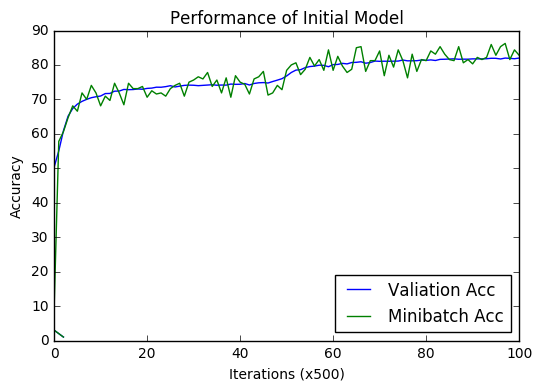

In [88]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.xlabel('Iterations (x500)')
plt.ylabel('Accuracy')
plt.title('Performance of Initial Model')
line_up, = plt.plot([3,2,1], label='Valiation Acc')
line_down, = plt.plot([3,2,1], label='Minibatch Acc')
plt.legend(handles=[line_up, line_down],loc=4)
plt.show()

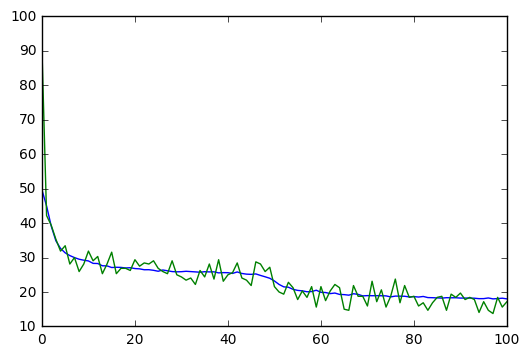

In [69]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [70]:
# restore model to calculate accuracy
with tf.Session(graph=graph) as session:
    saver.restore(session, "CNN_multi_all_color_1.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')


Model restored.
Initialized
Done


In [71]:
# calculate accuracy
acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

84.9831649832 84.8974594429
Test accuracy: 84.94


In [105]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16

dropout = 0.5


graph = tf.Graph()

with graph.as_default():


    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases  = tf.Variable(tf.constant(1.0, shape=[depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases  = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, num_hidden1], stddev=0.1))
    layer3_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    
    # Read Out layer
    out1_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out2_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out4_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out5_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset_0)
  
    # Model.
    def model(data, keep_prob=1.0):
        h_conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID') + layer1_biases)
        lrn = tf.nn.local_response_normalization(h_conv1)
        h_pool1 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, layer2_weights, [1,1,1,1], 'VALID') + layer2_biases)
        lrn = tf.nn.local_response_normalization(h_conv2)
        h_pool2 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, layer3_weights, [1,1,1,1], 'VALID') + layer3_biases)
        
        hidden = tf.nn.dropout(h_conv3, keep_prob)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        logits1 = tf.matmul(reshape, out1_w) + out1_b
        logits2 = tf.matmul(reshape, out2_w) + out2_b
        logits3 = tf.matmul(reshape, out3_w) + out3_b
        logits4 = tf.matmul(reshape, out4_w) + out4_b
        logits5 = tf.matmul(reshape, out5_w) + out5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout)
    
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1]))
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2]))
    loss_3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3]))
    loss_4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))
    loss_5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    loss   = loss_1+loss_2+loss_3+loss_4+loss_5
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    [tr_logits1, tr_logits2, tr_logits3, tr_logits4, tr_logits5] = model(tf_train_dataset)
    train_prediction = tf.pack([tf.nn.softmax(tr_logits1),\
                                tf.nn.softmax(tr_logits2),\
                                tf.nn.softmax(tr_logits3),\
                                tf.nn.softmax(tr_logits4),\
                                tf.nn.softmax(tr_logits5)])
    
    [v_logits1, v_logits2, v_logits3, v_logits4, v_logits5] = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(v_logits1),\
                                tf.nn.softmax(v_logits2),\
                                tf.nn.softmax(v_logits3),\
                                tf.nn.softmax(v_logits4),\
                                tf.nn.softmax(v_logits5)])
    
    [te_logits1, te_logits2, te_logits3, te_logits4, te_logits5] = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(te_logits1),\
                               tf.nn.softmax(te_logits2),\
                               tf.nn.softmax(te_logits3),\
                               tf.nn.softmax(te_logits4),\
                               tf.nn.softmax(te_logits5)])
    saver = tf.train.Saver()
    

In [106]:
num_steps = 50000

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "CNN_multi_all_color_2.ckpt")
    print("Model saved in file: %s" % save_path)

#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))

#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 16.880394, Minibatch acc: 4.1%, Validation acc: 51.6%
Step: 500, Minibatch loss: 5.651828, Minibatch acc: 64.4%, Validation acc: 61.6%
Step: 1000, Minibatch loss: 4.480737, Minibatch acc: 78.1%, Validation acc: 73.8%
Step: 1500, Minibatch loss: 4.312256, Minibatch acc: 75.9%, Validation acc: 78.7%
Step: 2000, Minibatch loss: 3.879230, Minibatch acc: 79.1%, Validation acc: 81.4%
Step: 2500, Minibatch loss: 3.818293, Minibatch acc: 79.1%, Validation acc: 83.3%
Step: 3000, Minibatch loss: 3.332914, Minibatch acc: 85.0%, Validation acc: 83.7%
Step: 3500, Minibatch loss: 3.129509, Minibatch acc: 86.2%, Validation acc: 85.3%
Step: 4000, Minibatch loss: 3.193943, Minibatch acc: 87.2%, Validation acc: 85.7%
Step: 4500, Minibatch loss: 2.816181, Minibatch acc: 88.4%, Validation acc: 86.6%
Step: 5000, Minibatch loss: 3.758049, Minibatch acc: 82.2%, Validation acc: 87.0%
Step: 5500, Minibatch loss: 3.311560, Minibatch acc: 84.1%, Validation acc: 87.0%
Step: 60

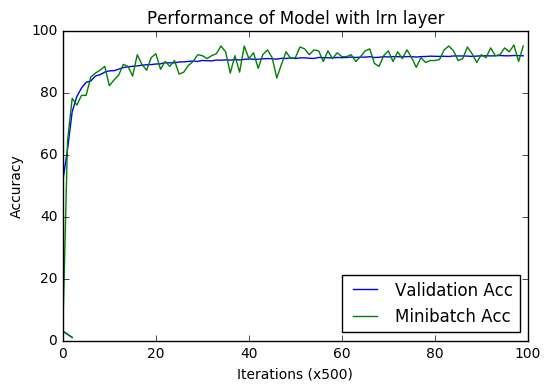

In [107]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.xlabel('Iterations (x500)')
plt.ylabel('Accuracy')
plt.title('Performance of Model with lrn layer')
line_up, = plt.plot([3,2,1], label='Validation Acc')
line_down, = plt.plot([3,2,1], label='Minibatch Acc')
plt.legend(handles=[line_up, line_down],loc=4)

plt.show()


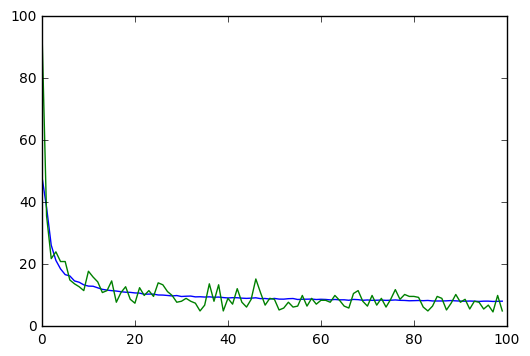

In [108]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [109]:
# reload model to calculate accuracy
with tf.Session(graph=graph) as session:
    saver.restore(session, "CNN_multi_all_color_2.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')


Model restored.
Initialized
Done


In [110]:
# calculate accuracy
acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

92.7456382002 92.479338843
Test accuracy: 92.61


In [194]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
#shape = [batch_size, image_size, image_size, num_channels]
dropout = 0.5


graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')


    # Model.
    def model(data, keep_prob, shape):
        conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout, shape)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])

    saver = tf.train.Saver()
    

In [195]:
num_steps = 50001

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "CNN_multi_all_color_3.ckpt")
    print("Model saved in file: %s" % save_path)

#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))

#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 19.357441, Minibatch acc: 4.1%, Validation acc: 47.4%
Step: 500, Minibatch loss: 6.086148, Minibatch acc: 60.0%, Validation acc: 57.1%
Step: 1000, Minibatch loss: 4.698959, Minibatch acc: 72.2%, Validation acc: 70.3%
Step: 1500, Minibatch loss: 4.654528, Minibatch acc: 78.1%, Validation acc: 77.4%
Step: 2000, Minibatch loss: 3.953730, Minibatch acc: 83.4%, Validation acc: 81.0%
Step: 2500, Minibatch loss: 3.712084, Minibatch acc: 81.6%, Validation acc: 82.7%
Step: 3000, Minibatch loss: 3.286994, Minibatch acc: 86.6%, Validation acc: 84.0%
Step: 3500, Minibatch loss: 3.295438, Minibatch acc: 85.6%, Validation acc: 85.1%
Step: 4000, Minibatch loss: 3.170310, Minibatch acc: 87.8%, Validation acc: 85.3%
Step: 4500, Minibatch loss: 2.869206, Minibatch acc: 85.9%, Validation acc: 86.5%
Step: 5000, Minibatch loss: 3.856149, Minibatch acc: 82.2%, Validation acc: 86.4%
Step: 5500, Minibatch loss: 3.440934, Minibatch acc: 82.2%, Validation acc: 87.1%
Step: 60

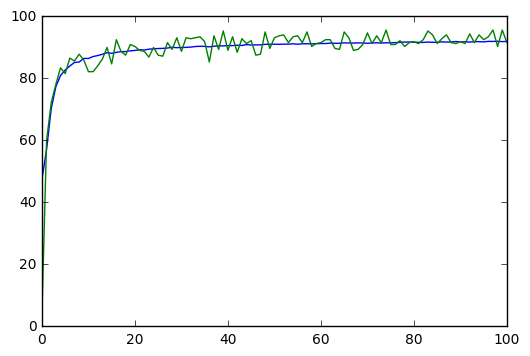

In [196]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.show()

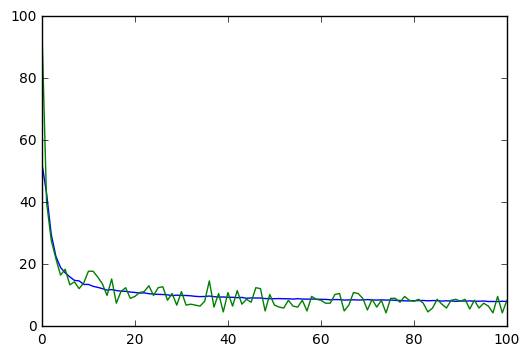

In [197]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [198]:
with tf.Session(graph=graph) as session:
    saver.restore(session, "CNN_multi_all_color_3.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')


Model restored.
Initialized
Done


In [199]:
acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

92.7517600245 92.721150903
Test accuracy: 92.74


In [ ]:
Below is a simple model v4 (increased number of units)
conv1
lrn
pool1
conv2
lrn
pool2
conv3
lrn
dropout
relu
dropout
read out

In [112]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
#depth3 = 64
num_hidden1 = 512
num_hidden2 = 256
shape = [batch_size, image_size, image_size, num_channels]
dropout = 0.75

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases  = tf.Variable(tf.constant(1.0, shape=[depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases  = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, num_hidden1], stddev=0.1))
    layer3_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
    layer4_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))

    # Read Out layer
    out1_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out2_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out3_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out4_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out5_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data, keep_prob=1.0):
        h_conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID') + layer1_biases)
        lrn = tf.nn.local_response_normalization(h_conv1)
        h_pool1 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, layer2_weights, [1,1,1,1], 'VALID') + layer2_biases)
        lrn = tf.nn.local_response_normalization(h_conv2)
        h_pool2 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, layer3_weights, [1,1,1,1], 'VALID') + layer3_biases)
        lrn = tf.nn.local_response_normalization(h_conv3)
        
        hidden = tf.nn.dropout(h_conv3, keep_prob)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        hidden1 = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        reshape1 = tf.nn.dropout(hidden1, keep_prob)

        logits1 = tf.matmul(reshape1, out1_w) + out1_b
        logits2 = tf.matmul(reshape1, out2_w) + out2_b
        logits3 = tf.matmul(reshape1, out3_w) + out3_b
        logits4 = tf.matmul(reshape1, out4_w) + out4_b
        logits5 = tf.matmul(reshape1, out5_w) + out5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout)
    
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1]))
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2]))
    loss_3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3]))
    loss_4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))
    loss_5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    loss   = loss_1+loss_2+loss_3+loss_4+loss_5
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    [tr_logits1, tr_logits2, tr_logits3, tr_logits4, tr_logits5] = model(tf_train_dataset)
    train_prediction = tf.pack([tf.nn.softmax(tr_logits1),\
                                tf.nn.softmax(tr_logits2),\
                                tf.nn.softmax(tr_logits3),\
                                tf.nn.softmax(tr_logits4),\
                                tf.nn.softmax(tr_logits5)])
    
    [v_logits1, v_logits2, v_logits3, v_logits4, v_logits5] = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(v_logits1),\
                                tf.nn.softmax(v_logits2),\
                                tf.nn.softmax(v_logits3),\
                                tf.nn.softmax(v_logits4),\
                                tf.nn.softmax(v_logits5)])
    
    [te_logits1, te_logits2, te_logits3, te_logits4, te_logits5] = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(te_logits1),\
                               tf.nn.softmax(te_logits2),\
                               tf.nn.softmax(te_logits3),\
                               tf.nn.softmax(te_logits4),\
                               tf.nn.softmax(te_logits5)])
    saver = tf.train.Saver()


In [114]:
num_steps = 50001

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)


        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "CNN_multi_all_color_9.ckpt")
    print("Model saved in file: %s" % save_path)

#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))
#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 30.683546, Minibatch acc: 16.6%, Validation acc: 53.5%
Step: 500, Minibatch loss: 5.800131, Minibatch acc: 62.2%, Validation acc: 58.7%
Step: 1000, Minibatch loss: 4.382001, Minibatch acc: 76.9%, Validation acc: 71.5%
Step: 1500, Minibatch loss: 3.588098, Minibatch acc: 78.4%, Validation acc: 80.3%
Step: 2000, Minibatch loss: 3.217901, Minibatch acc: 83.1%, Validation acc: 84.4%
Step: 2500, Minibatch loss: 3.110260, Minibatch acc: 86.2%, Validation acc: 86.3%
Step: 3000, Minibatch loss: 2.131971, Minibatch acc: 88.8%, Validation acc: 87.8%
Step: 3500, Minibatch loss: 1.886651, Minibatch acc: 91.6%, Validation acc: 89.0%
Step: 4000, Minibatch loss: 1.815448, Minibatch acc: 93.1%, Validation acc: 88.9%
Step: 4500, Minibatch loss: 1.898637, Minibatch acc: 90.0%, Validation acc: 90.2%
Step: 5000, Minibatch loss: 2.736697, Minibatch acc: 87.5%, Validation acc: 90.5%
Step: 5500, Minibatch loss: 2.394086, Minibatch acc: 87.5%, Validation acc: 90.7%
Step: 6

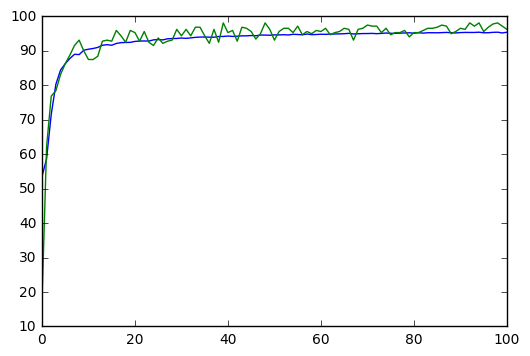

In [115]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.show()

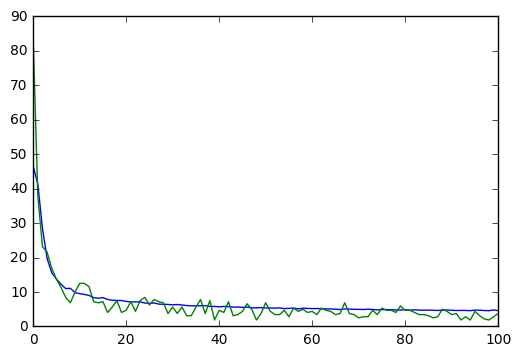

In [116]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [117]:
# load model to calculate accuracy
with tf.Session(graph=graph) as session:
    saver.restore(session, "CNN_multi_all_color_9.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')

acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

Model restored.
Initialized
Done
94.9280685644 95.1484542394
Test accuracy: 95.04


In [ ]:
Below is a simple model v5 (increased number of units, depth)
conv1
lrn
pool1
conv2
lrn
pool2
conv3
lrn
dropout
relu
dropout
read out

In [124]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 32
depth2 = 64
#depth3 = 64
num_hidden1 = 512
num_hidden2 = 256
shape = [batch_size, image_size, image_size, num_channels]
dropout = 0.75

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases  = tf.Variable(tf.constant(1.0, shape=[depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases  = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, num_hidden1], stddev=0.1))
    layer3_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
    layer4_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))

    # Read Out layer
    out1_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out2_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out3_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out4_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out5_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data, keep_prob=1.0):
        h_conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID') + layer1_biases)
        lrn = tf.nn.local_response_normalization(h_conv1)
        h_pool1 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, layer2_weights, [1,1,1,1], 'VALID') + layer2_biases)
        lrn = tf.nn.local_response_normalization(h_conv2)
        h_pool2 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, layer3_weights, [1,1,1,1], 'VALID') + layer3_biases)
        lrn = tf.nn.local_response_normalization(h_conv3)
        
        hidden = tf.nn.dropout(h_conv3, keep_prob)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        hidden1 = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        reshape1 = tf.nn.dropout(hidden1, keep_prob)

        logits1 = tf.matmul(reshape1, out1_w) + out1_b
        logits2 = tf.matmul(reshape1, out2_w) + out2_b
        logits3 = tf.matmul(reshape1, out3_w) + out3_b
        logits4 = tf.matmul(reshape1, out4_w) + out4_b
        logits5 = tf.matmul(reshape1, out5_w) + out5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout)
    
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1]))
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2]))
    loss_3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3]))
    loss_4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))
    loss_5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    loss   = loss_1+loss_2+loss_3+loss_4+loss_5
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    [tr_logits1, tr_logits2, tr_logits3, tr_logits4, tr_logits5] = model(tf_train_dataset)
    train_prediction = tf.pack([tf.nn.softmax(tr_logits1),\
                                tf.nn.softmax(tr_logits2),\
                                tf.nn.softmax(tr_logits3),\
                                tf.nn.softmax(tr_logits4),\
                                tf.nn.softmax(tr_logits5)])
    
    [v_logits1, v_logits2, v_logits3, v_logits4, v_logits5] = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(v_logits1),\
                                tf.nn.softmax(v_logits2),\
                                tf.nn.softmax(v_logits3),\
                                tf.nn.softmax(v_logits4),\
                                tf.nn.softmax(v_logits5)])
    
    [te_logits1, te_logits2, te_logits3, te_logits4, te_logits5] = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(te_logits1),\
                               tf.nn.softmax(te_logits2),\
                               tf.nn.softmax(te_logits3),\
                               tf.nn.softmax(te_logits4),\
                               tf.nn.softmax(te_logits5)])
    saver = tf.train.Saver()


In [125]:
num_steps = 50001

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)


        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "CNN_multi_all_color_17.ckpt")
    print("Model saved in file: %s" % save_path)

#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))
#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 30.734692, Minibatch acc: 7.8%, Validation acc: 51.6%
Step: 500, Minibatch loss: 6.347945, Minibatch acc: 57.8%, Validation acc: 55.0%
Step: 1000, Minibatch loss: 6.555174, Minibatch acc: 55.0%, Validation acc: 55.4%
Step: 1500, Minibatch loss: 6.483354, Minibatch acc: 54.7%, Validation acc: 55.7%
Step: 2000, Minibatch loss: 5.852816, Minibatch acc: 59.7%, Validation acc: 59.9%
Step: 2500, Minibatch loss: 5.318780, Minibatch acc: 69.7%, Validation acc: 70.2%
Step: 3000, Minibatch loss: 3.555915, Minibatch acc: 83.8%, Validation acc: 77.5%
Step: 3500, Minibatch loss: 3.126567, Minibatch acc: 82.2%, Validation acc: 81.5%
Step: 4000, Minibatch loss: 2.316647, Minibatch acc: 88.4%, Validation acc: 84.9%
Step: 4500, Minibatch loss: 2.164342, Minibatch acc: 88.8%, Validation acc: 87.1%
Step: 5000, Minibatch loss: 2.810972, Minibatch acc: 84.4%, Validation acc: 87.6%
Step: 5500, Minibatch loss: 2.878226, Minibatch acc: 86.9%, Validation acc: 88.3%
Step: 60

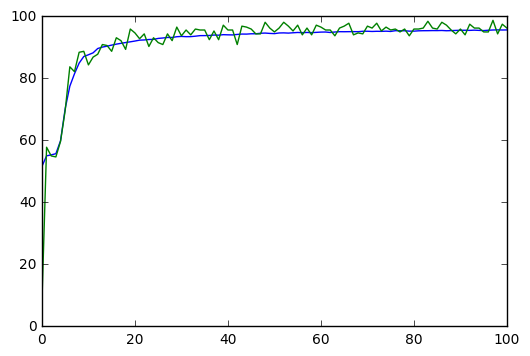

In [126]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.show()

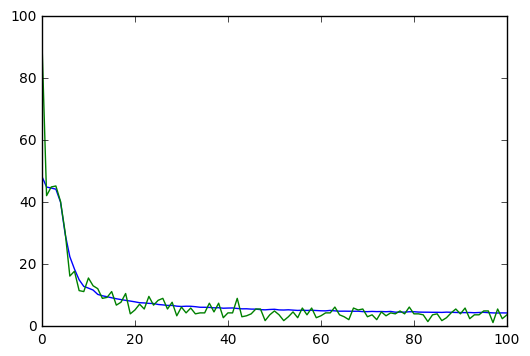

In [127]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [128]:
with tf.Session(graph=graph) as session:
    saver.restore(session, "CNN_multi_all_color_17.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')

acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

Model restored.
Initialized
Done
95.182124273 95.3841444751
Test accuracy: 95.28


In [142]:
debug_arr=np.arange(len(test_labels))
np.random.shuffle(debug_arr)
shuffle_debug=debug_arr[0:4]
print(shuffle_debug)

[ 7780    84 11077 10052]


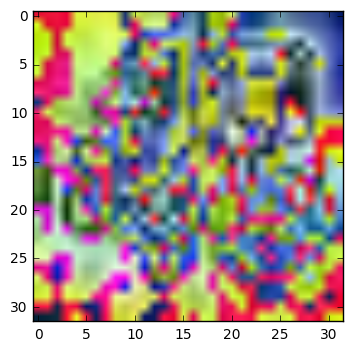

In [164]:
img_test=test_dataset[61]
imgplot = plt.imshow(img_test)
plt.show()

In [172]:
kk=[0,1]
print(test_labels[shuffle_debug[kk]])
#print(test_prediction_0[:,shuffle_debug[kk],:])
np.argmax(test_prediction_0,2).T[kk],test_labels[kk]

[[ 2  7  8 10 10 10]
 [ 3  7  3  0 10 10]]


(array([[ 5, 10, 10, 10, 10],
        [ 1,  0, 10, 10, 10]]), array([[ 1,  5, 10, 10, 10, 10],
        [ 2,  1,  6, 10, 10, 10]]))

In [193]:
#np.argmax(test_prediction_0,2).T[1],test_labels[1]
jj=0
print( test_labels[jj])
print(np.argmax(test_prediction_0,2).T[jj])

[ 1  5 10 10 10 10]
[ 5 10 10 10 10]


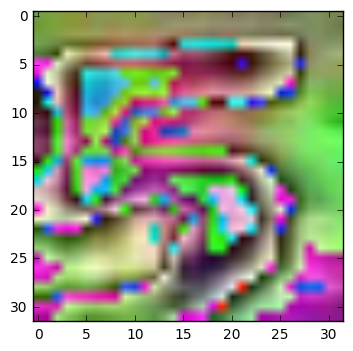

In [192]:
img_test=test_dataset[0]
imgplot = plt.imshow(img_test)
plt.show()

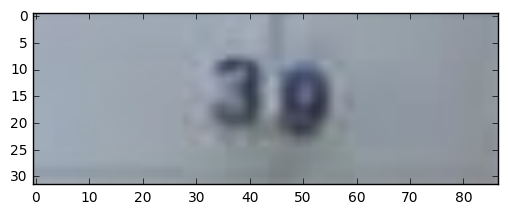

In [191]:
# DEBUG CODE: can be ignored
# print 1st odd image
import os
from PIL import Image
odd_img='4833.png'
fpath=os.path.join('test', odd_img)
my_img=Image.open(fpath)

import matplotlib.pyplot as plt
%matplotlib inline
imgplot=plt.imshow(my_img,cmap='Greys_r')

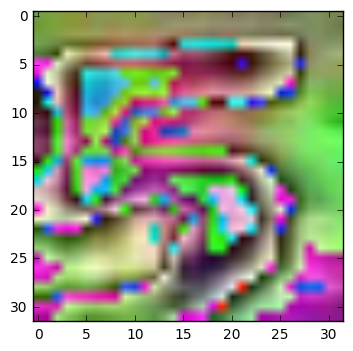

In [136]:
plt.show()

In [130]:
debug_arr

array([    0,     1,     2, ..., 13065, 13066, 13067])

In [41]:
#test_prediction=np.concatenate(test_prediction_0[],test_prediction_1)
test_prediction_0.shape,test_prediction_1.shape

((5, 6534, 11), (5, 6534, 11))

In [33]:
test_labels[0]

array([ 1,  5, 10, 10, 10, 10])

In [49]:
np.argmax(test_prediction_0,2).T[0],test_labels[0]

(array([ 5, 10, 10, 10, 10]), array([ 1,  5, 10, 10, 10, 10]))

In [51]:
test_prediction_0[:,0,:]

array([[  4.38798033e-03,   1.15677640e-02,   1.89180318e-02,
          1.26550391e-01,   6.05386384e-02,   5.64205110e-01,
          8.61856490e-02,   4.71076369e-03,   3.82323712e-02,
          8.47031549e-02,   2.89760937e-10],
       [  3.13096461e-05,   5.04834484e-03,   2.79419201e-05,
          8.70717864e-04,   4.30756918e-05,   7.34134112e-04,
          2.58232671e-04,   1.30807364e-03,   9.43065897e-05,
          4.34994494e-04,   9.91148829e-01],
       [  3.30287672e-11,   1.88624301e-06,   2.10780594e-11,
          2.90184377e-10,   1.87774615e-10,   2.95049297e-11,
          8.74088357e-10,   1.00115281e-11,   3.24931609e-10,
          3.03402956e-08,   9.99998093e-01],
       [  7.50071868e-16,   1.56400379e-10,   9.56429105e-17,
          9.78520254e-17,   1.40784489e-15,   1.53367253e-16,
          5.28994906e-17,   3.04055902e-15,   6.16813469e-16,
          2.32421504e-14,   1.00000000e+00],
       [  2.37339796e-15,   1.37611387e-15,   1.49224177e-16,
          6.35

In [40]:
test_prediction_0.shape[0], test_prediction_0.shape[1]

(5, 6534)

In [ ]:
#test_prediction=np.concatenate(test_prediction_0[],test_prediction_1)
test_prediction_0.shape,test_prediction_1.shape

In [ ]:
# build a simple model

# initialize variables
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color image

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
#depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]
dropout = 0.5

